# Touch Detection Prototyping

## Goals and Requirements

### Input

The raw touch input is provided as capacitive heatmap.
The resolution of this heatmap is significantly lower than the resolution of the actual screen, which in turn may be lower than the final resolution in which the processed touch point descriptions should be provided.
The input is likely noisy, thus additional precautions may be necessary.

### Output

This project is mainly intended to provide a robust algorithm for use in a Linux kernel module.
In the Linux kernel, touch points can be described via an ellipse representing the contact point (see https://www.kernel.org/doc/html/latest/input/multi-touch-protocol.html for details).
Note: We will for now neglect the appropriate scaling of coordinates to output dimensions.
Thus the provided output for some touch point $i$ is $t_i = (c_i, \theta_i, h_i, w_i)$ with

- $c_i \in \mathbb{R}^{2}$ as the center of the contact point,
- $h_i \in \mathbb{R}$ as the height of the ellipse, i.e. its size along its major axis,
- $w_i \in \mathbb{R}$ as the width of the ellipse, i.e. its size along its minor axis (note that the axes are orthogonal), and
- $\theta_i \in [0,2\pi]$ as the angle of the major axis of the ellipse.

In addition, proper handling of touch points requires tracking of the contact points across consecutive input data frames.
This can be seen as a separate problem ontop of the contact point identification and will be discussed later.

## First Approach: A Simplified Setting

Let us for now assume that we only have a single point of contact.
Considering that we need to model the contact point as an ellipse, a two-dimensional Gaussian $\mathcal{N}(x \mid \mu, \Sigma)$ seems like a good choice to start: The mean $\mu \in \mathbb{R}^2$ of the Gaussian directly provides us with the center of the contact point while a confidence bound derived from the covariance matrix $\Sigma \in \mathbb{R}^{2 \times 2}$ provides us with the shape of the ellipse.
This also allows for a neat probabilistic interpretation: $\mathcal{N}(x \mid \mu, \Sigma)$ represents the probability of $x \in \mathbb{R}^2$ being the center of the contact area.

Estimation of the Gaussian is fairly straightforward.
Note that we, however, do not deal with uniformly weighted random samples but instead with a grid, where points have associated values derived from the capacity data of the touchscreen, determining their sample weights.
This suggests modifying the classical maximum likelihood estimators (MLE), yielding

\begin{align*}
    \mathbb{E}[\mu] &= \sum_{(x_i, y_i) \in \mathcal{S}} y_i \cdot x_i \\
    \mathbb{E}[\Sigma] &= \sum_{(x_i, y_i) \in \mathcal{S}} y_i \cdot \left(x - \mu\right)
        \left(x - \mu\right)^\intercal
\end{align*}

where $S$ is the set of samples $x_i \in \mathbb{R}^2$ associated with normalized sample weights $y_i \in \mathbb{R}$, such that $\sum_i y_i = 1$ holds.

Let us now apply this.
First we generate some input data for a single contact point, using a Gaussian:

In [1]:
# imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
%matplotlib notebook

In [2]:
# general parameters
input_width, input_height = 0x48, 0x30
data = np.zeros(shape=(input_width, input_height))

In [3]:
def cov(angle, width, height):
    """Generate a 2D covariance matrix from the given confidence bound shape"""
    e1 = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]) @ np.array([1.0, 0.0])
    e2 = np.array([[0.0, -1.0], [1.0, 0.0]]) @ e1
    return height * np.outer(e1, e1) + width * np.outer(e2, e2)

# parameters for data
mu_real = np.array([15.3, 10.6])
sigma_real = cov(np.deg2rad(35), 1.0, 2.0)

# simulate input data
for x1 in range(0, data.shape[0]):
    for x2 in range(0, data.shape[1]):
        data[x1, x2] += multivariate_normal.pdf(np.array([x1, x2]), mu_real, sigma_real)

<IPython.core.display.Javascript object>


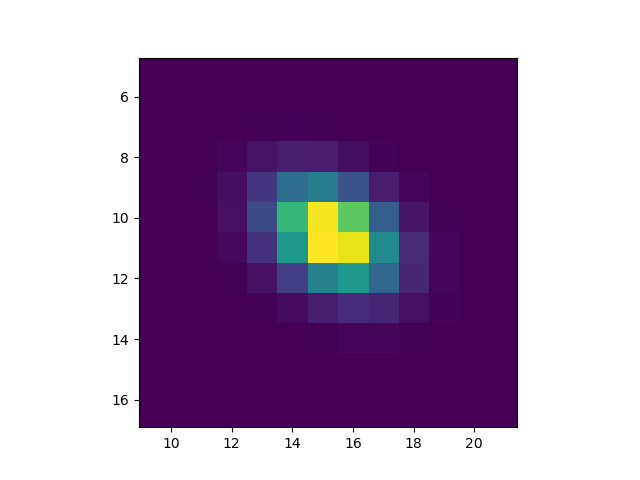

In [4]:
_fig, ax = plt.subplots()
ax.imshow(data.T)
plt.show()

Now let's try to reconstruct the parameters for the original Gaussian using the MLEs.
First estimate the mean $\mu$:

In [5]:
def mle_mean(data):
    mu = np.zeros(shape=2)

    for x1 in range(0, data.shape[0]):
        for x2 in range(0, data.shape[1]):
            mu += np.array([x1, x2]) * data[x1, x2]

    return mu

mu = mle_mean(data)

and from that estimate the covariance matrix $\Sigma$:

In [6]:
def mle_cov(data):
    sigma = np.zeros(shape=(2, 2))

    for x1 in range(0, data.shape[0]):
        for x2 in range(0, data.shape[1]):
            d = np.array([x1, x2]) - mu
            sigma += np.outer(d, d) * data[x1, x2]
    
    return sigma

sigma = mle_cov(data)

To see how good this estimate is we can first look at the errors

In [7]:
print(f"error in mu:    {np.linalg.norm(mu_real - mu)}")
print(f"error in sigma: {np.linalg.norm(sigma_real - sigma, ord=np.inf)}")

error in mu:    9.124653467372391e-11
error in sigma: 6.062403357098844e-10


and then also plot the results:

In [8]:
from matplotlib.patches import Ellipse

def plot_cov_ellipse(ax, mu, sigma, nstd, **kwargs):
    """Plot ellipse representing confidence bound with nstd times the standard deviation"""
    eigvals, eigvecs = np.linalg.eigh(sigma)

    vx, vy = eigvecs[:, 0][0], eigvecs[:, 0][1]
    angle = np.arctan2(vy, vx)

    width, height = 2.0 * nstd * np.sqrt(eigvals)
    ax.add_artist(Ellipse(xy=mu, width=width, height=height, angle=np.degrees(angle), **kwargs))

def plot_gaussian(ax, mu, sigma, nstd, color):
    """Plot Gaussian with confidence bound"""
    # plot mean
    ax.plot([mu[0], mu[0]], [mu[1] - 0.5, mu[1] + 0.5], color=color)
    ax.plot([mu[0] - 0.5, mu[0] + 0.5], [mu[1], mu[1]], color=color)
        
    # plot confidence ellipse
    plot_cov_ellipse(ax, mu, sigma_real, 2.0, facecolor='none', edgecolor='red')
    

<IPython.core.display.Javascript object>


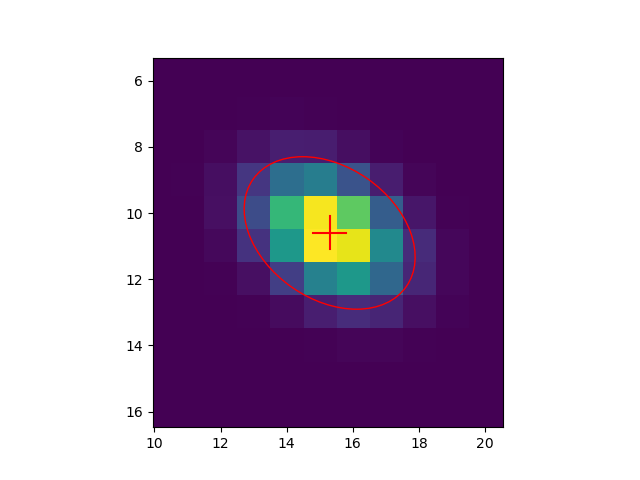

In [9]:
_fig, ax = plt.subplots()
ax.imshow(data.T)
plot_gaussian(ax, mu, sigma, 2.0, color='red')